# Dissecting Spotify Valence

The scope of this project is to dissect Spotify's Valence metric.


---

> Ioannis Dekoulakos <br />
> Athens University of Economics and Business <br />
> Business Analytics Practicum I - PT <br />
> A.M.: P2822110

Spotify uses a metric called valence to measure the happiness of a track. The metric itself, however, was not developed by Spotify. It was originally developed by Echo Nest, a company that was bought by Spotify in 2014. We don't know exactly how valence is calculated. Some details are given by a blog post, which you can find [here](https://web.archive.org/web/20170422195736/http://blog.echonest.com/post/66097438564/plotting-musics-emotional-valence-1950-2013)


The task is to untangle the mystery behind valence and propose how this is derived. 


Spotify offers the following information that may be relevant to your task:


- [Get Track's Audio Features ](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) .
- [Get Track's Audio Analysis](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-analysis).


To achieve that we will download a [dataset](https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db) of songs from Kaggle. Due to the fact that we do not know how the features have been collected , we will use only the Ids of tracks . Then using the [API](https://developer.spotify.com/documentation/web-api/reference/#/) of Spotify , we will download the original audio features of each song.





## DATA

In [14]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import glob
import re
from datetime import datetime

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [15]:
songs = pd.read_csv("SpotifyFeatures.csv", usecols=['track_id', 'track_name'])
songs

,track_name,track_id
0,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV
1,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP
2,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy
3,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf
4,Ouverture,0IuslXpMROHdEPvSl1fTQK
...,...,...
232720,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT
232721,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM
232722,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t
232723,With My Words,6EFsue2YbIG4Qkq8Zr9Rir


- Let's see if there are duplicate track's names or ids and remove them 

In [413]:
len(songs['track_id'].unique())

176774

In [414]:
songs.drop_duplicates(subset='track_id', inplace=True)
songs.drop_duplicates(subset='track_name', inplace=True)
songs

,track_name,track_id
0,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV
1,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP
2,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy
3,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf
4,Ouverture,0IuslXpMROHdEPvSl1fTQK
...,...,...
232714,They Like It Slow,2XoAEpBuM4AtQIQYUEowRy
232716,Quickly (feat. Brandy),1U0OMWvR89Cm20vCNar50f
232717,P.O.P.,2gGqKJWfWbToha2YmDxnnj
232721,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM


### Connection with API


#### Our credentials

- Client ID: e6d084f421cf4399bc2df62483af93f9

- Client Secret 0927ed2942164a45abad9a72a5998bc0

In [415]:
client_credentials_manager = SpotifyClientCredentials('e6d084f421cf4399bc2df62483af93f9',
                                                     '0927ed2942164a45abad9a72a5998bc0')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [416]:
features = {}
all_track_ids = list(songs['track_id'])

In [417]:
def get_features(list_of_ids):
    
    features_func = {}
    all_track_ids = list_of_ids 

    start = 0
    num_tracks = 100
    while start < len(all_track_ids):
        
        tracks_batch = all_track_ids[start:start+num_tracks]
        features_batch = sp.audio_features(tracks_batch)
        features_func.update({ track_id : track_features 
                        for track_id, track_features in zip(tracks_batch, features_batch) })
        start += num_tracks
    return features_func

- Spotify permits a max 100 song ids per batch

In [418]:
audio_features = get_features(all_track_ids)

In [419]:
len(audio_features)

148400

The features look like :

In [420]:
audio_features['0IuslXpMROHdEPvSl1fTQK']

{'danceability': 0.331,
 'energy': 0.225,
 'key': 5,
 'loudness': -21.15,
 'mode': 1,
 'speechiness': 0.0456,
 'acousticness': 0.95,
 'instrumentalness': 0.123,
 'liveness': 0.202,
 'valence': 0.39,
 'tempo': 140.576,
 'type': 'audio_features',
 'id': '0IuslXpMROHdEPvSl1fTQK',
 'uri': 'spotify:track:0IuslXpMROHdEPvSl1fTQK',
 'track_href': 'https://api.spotify.com/v1/tracks/0IuslXpMROHdEPvSl1fTQK',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0IuslXpMROHdEPvSl1fTQK',
 'duration_ms': 82625,
 'time_signature': 4}

- So, We'll turn the dictionary to a DataFrame.

In [421]:
tracks = pd.DataFrame.from_dict(audio_features, orient='index')
tracks

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0BRjO6ga9RKCKjfDqeFgWV,0.389,0.910,1,-1.828,1,0.0525,0.6110,0.000000,0.3460,0.816,166.969,audio_features,0BRjO6ga9RKCKjfDqeFgWV,spotify:track:0BRjO6ga9RKCKjfDqeFgWV,https://api.spotify.com/v1/tracks/0BRjO6ga9RKC...,https://api.spotify.com/v1/audio-analysis/0BRj...,99373,4
0BjC1NfoEOOusryehmNudP,0.591,0.737,6,-5.559,0,0.0877,0.2460,0.000000,0.1510,0.815,174.003,audio_features,0BjC1NfoEOOusryehmNudP,spotify:track:0BjC1NfoEOOusryehmNudP,https://api.spotify.com/v1/tracks/0BjC1NfoEOOu...,https://api.spotify.com/v1/audio-analysis/0BjC...,137373,4
0CoSDzoNIKCRs124s9uTVy,0.663,0.131,0,-13.879,0,0.0362,0.9520,0.000000,0.1030,0.368,99.488,audio_features,0CoSDzoNIKCRs124s9uTVy,spotify:track:0CoSDzoNIKCRs124s9uTVy,https://api.spotify.com/v1/tracks/0CoSDzoNIKCR...,https://api.spotify.com/v1/audio-analysis/0CoS...,170267,5
0Gc6TVm52BwZD07Ki6tIvf,0.241,0.326,1,-12.178,1,0.0390,0.7030,0.000000,0.0985,0.226,171.782,audio_features,0Gc6TVm52BwZD07Ki6tIvf,spotify:track:0Gc6TVm52BwZD07Ki6tIvf,https://api.spotify.com/v1/tracks/0Gc6TVm52BwZ...,https://api.spotify.com/v1/audio-analysis/0Gc6...,152427,4
0IuslXpMROHdEPvSl1fTQK,0.331,0.225,5,-21.150,1,0.0456,0.9500,0.123000,0.2020,0.390,140.576,audio_features,0IuslXpMROHdEPvSl1fTQK,spotify:track:0IuslXpMROHdEPvSl1fTQK,https://api.spotify.com/v1/tracks/0IuslXpMROHd...,https://api.spotify.com/v1/audio-analysis/0Ius...,82625,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2XoAEpBuM4AtQIQYUEowRy,0.611,0.493,1,-9.297,1,0.0354,0.1130,0.000000,0.1050,0.443,115.920,audio_features,2XoAEpBuM4AtQIQYUEowRy,spotify:track:2XoAEpBuM4AtQIQYUEowRy,https://api.spotify.com/v1/tracks/2XoAEpBuM4At...,https://api.spotify.com/v1/audio-analysis/2XoA...,279510,4
1U0OMWvR89Cm20vCNar50f,0.736,0.701,10,-4.345,0,0.1000,0.2310,0.000000,0.2030,0.770,99.991,audio_features,1U0OMWvR89Cm20vCNar50f,spotify:track:1U0OMWvR89Cm20vCNar50f,https://api.spotify.com/v1/tracks/1U0OMWvR89Cm...,https://api.spotify.com/v1/audio-analysis/1U0O...,222667,4
2gGqKJWfWbToha2YmDxnnj,0.802,0.516,2,-9.014,1,0.2140,0.1040,0.000472,0.1050,0.482,175.663,audio_features,2gGqKJWfWbToha2YmDxnnj,spotify:track:2gGqKJWfWbToha2YmDxnnj,https://api.spotify.com/v1/tracks/2gGqKJWfWbTo...,https://api.spotify.com/v1/audio-analysis/2gGq...,201173,4
1qWZdkBl4UVPj9lK6HuuFM,0.785,0.683,4,-6.944,0,0.0337,0.0329,0.000880,0.2370,0.969,113.830,audio_features,1qWZdkBl4UVPj9lK6HuuFM,spotify:track:1qWZdkBl4UVPj9lK6HuuFM,https://api.spotify.com/v1/tracks/1qWZdkBl4UVP...,https://api.spotify.com/v1/audio-analysis/1qWZ...,282447,4


- Check for Nas

In [422]:
tracks.isna().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64

- Drop the columns which are not usefull 

In [423]:
tracks = tracks.drop(['type','id','uri','track_href','analysis_url'],axis=1)

###### Some Statistics

In [424]:
tracks.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,148400.000000,148400.000000,148400.000000,148400.000000,148400.000000,148400.000000,148400.000000,148400.000000,148400.000000,148400.000000,148400.000000,1.484000e+05,148400.000000
mean,0.535445,0.551864,5.223787,-10.391218,0.660094,0.130239,0.415219,0.181965,0.228590,0.448268,116.970721,2.380113e+05,3.861853
std,0.193220,0.281234,3.544840,6.626681,0.473678,0.209596,0.371143,0.330389,0.215229,0.269956,31.386217,1.369600e+05,0.505556
min,0.000000,0.000020,0.000000,-52.458000,0.000000,0.000000,0.000000,0.000000,0.009670,0.000000,0.000000,1.538700e+04,0.000000
25%,0.405000,0.329000,2.000000,-13.316000,0.000000,0.037000,0.047300,0.000000,0.097700,0.215000,91.891250,1.773330e+05,4.000000
50%,0.553000,0.589000,5.000000,-8.330000,1.000000,0.049500,0.305000,0.000088,0.131000,0.436000,114.936000,2.199730e+05,4.000000
75%,0.680000,0.791000,8.000000,-5.663000,1.000000,0.102000,0.810000,0.131000,0.284000,0.666000,138.367000,2.708670e+05,4.000000
max,0.987000,0.999000,11.000000,3.744000,1.000000,0.967000,0.996000,0.999000,1.000000,1.000000,243.372000,5.552917e+06,5.000000


- We know that the time signature ranges from 3 to 7 , so we will remove the songs with invalid value

In [425]:
tracks = tracks[(tracks.time_signature >=3)]

array([[<AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'loudness'}>],
       [<AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>],
       [<AxesSubplot:title={'center':'liveness'}>,
        <AxesSubplot:title={'center':'valence'}>,
        <AxesSubplot:title={'center':'tempo'}>,
        <AxesSubplot:title={'center':'duration_ms'}>],
       [<AxesSubplot:title={'center':'time_signature'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

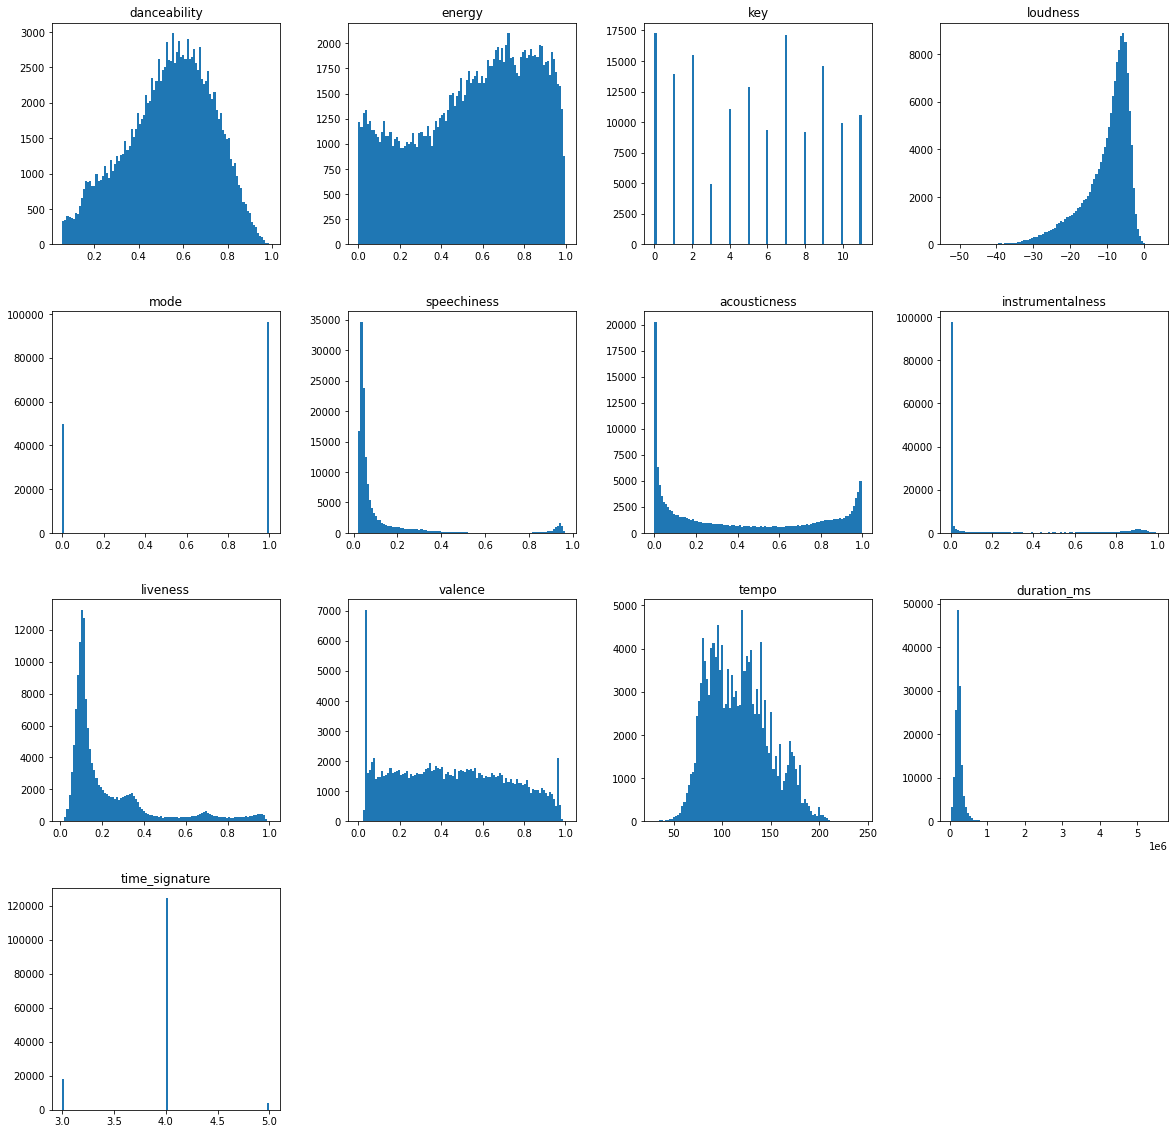

In [426]:
tracks.hist(grid=False ,bins = 100,figsize= [20, 20])

- We can see that the variables: time_signature , mode & key make more sense to be ordinal (One hot encode categorical columns)


- Also,  maybe some variables need to be scaled if we use any machine learning method which uses distances

## Q1: Expore which Track Features Influence Valence

In [427]:
data=tracks.copy()

#### Numerical Variables

In [428]:
numeric_data=data[data.columns.difference(['key','mode','time_signature'])]


- **Corellations**

In [429]:
py_cor_matrix = numeric_data.corr(method="pearson")

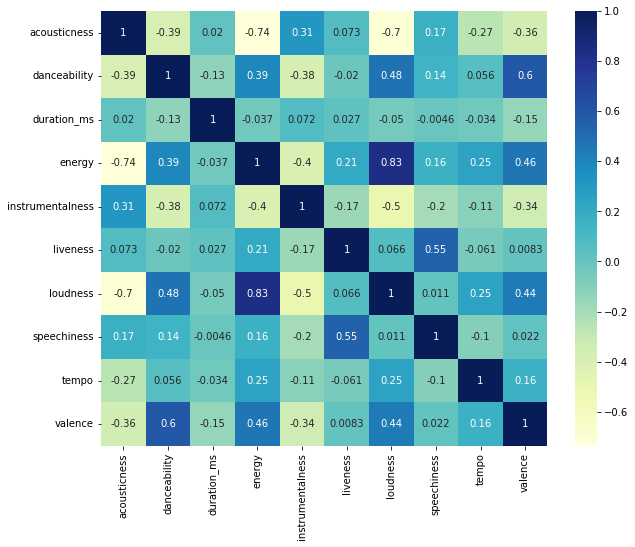

In [430]:
plt.figure(figsize=(10,8))
sns.heatmap(py_cor_matrix, annot=True, cmap="YlGnBu")
plt.show()

-  danceability-loudness&energy , energy-loudness, liveness-speechiness seems to have relations , so it is expected not to be used in all of them in the final model, since they offer the same information

- Most linear correlations variables with valence:

In [431]:
most_linear=np.abs(py_cor_matrix ['valence'])
most_linear.sort_values(ascending=False)

valence             1.000000
danceability        0.596080
energy              0.460062
loudness            0.438934
acousticness        0.359347
instrumentalness    0.340644
tempo               0.164666
duration_ms         0.148070
speechiness         0.021881
liveness            0.008284
Name: valence, dtype: float64

##### Catecorical Variables

We transformed into catecorical, the variables which we have mentioned before **ONLY** for EDA analysis. For modeling and machines learning methods we will use one hot encoding 

In [432]:
categorical_data=data[['valence','key','mode','time_signature']].copy()

In [433]:
categorical_data['key']=categorical_data['key'].astype('category')
categorical_data['mode']=categorical_data['mode'].astype('category')
categorical_data['time_signature']=categorical_data['time_signature'].astype('category')


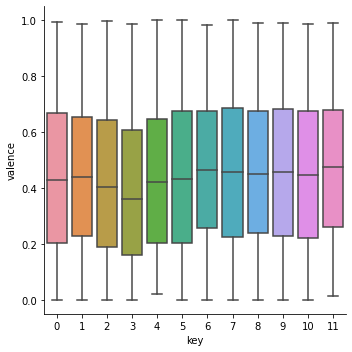

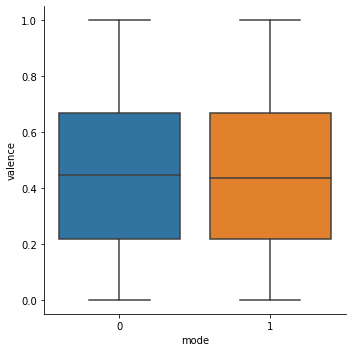

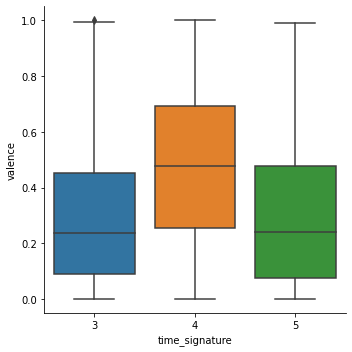

In [434]:
sns.catplot(x="key", y="valence", kind="box",  data=categorical_data)
sns.catplot(x="mode", y="valence", kind="box", data=categorical_data)
sns.catplot(x="time_signature", y="valence", kind="box", data=categorical_data)

- It seems that there is not any difference in the medians of mode so so we conclude that there is not association between the mode and valence and it is expected not to be used in the final model.

- We make some anova tests to check if these variables are statistically significant  

In [435]:
pip install bioinfokit

Note: you may need to restart the kernel to use updated packages.


In [436]:
import bioinfokit.analys 
from bioinfokit.analys import stat
res = stat()
res.anova_stat(df=categorical_data, res_var='value', anova_model='valence ~ C(key)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(key),11.0,38.410573,3.491870,48.165823,2.205424e-106
Residual,146316.0,10607.448665,0.072497,NaN,NaN


**valence ~ key**
- pvalue < 0.05 , statistically significant

In [437]:
res = stat()
res.anova_stat(df=categorical_data, res_var='value', anova_model='valence ~ C(mode)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(mode),1.0,0.001165,0.001165,0.016009,0.899314
Residual,146326.0,10645.858074,0.072754,NaN,NaN


**valence ~ mode**
- pvalue > 0.05 , it is not statistically significant as we see from the boxplot as well

In [438]:
res = stat()
res.anova_stat(df=categorical_data, res_var='value', anova_model='valence ~ C(time_signature)')
res.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(time_signature),2.0,608.355688,304.177844,4434.252278,0.0
Residual,146325.0,10037.503551,0.068597,NaN,NaN


**valence ~ time_signature**
- pvalue < 0.05 , , statistically significant

#### One hot encoding

In [439]:
mode_dummies = pd.get_dummies(data['mode'], prefix='mode', drop_first=True)
data.drop(columns='mode', inplace=True)
data = data.join(mode_dummies)
data.head(2)

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,mode_1
0BRjO6ga9RKCKjfDqeFgWV,0.389,0.910,1,-1.828,0.0525,0.611,0.0,0.346,0.816,166.969,99373,4,1
0BjC1NfoEOOusryehmNudP,0.591,0.737,6,-5.559,0.0877,0.246,0.0,0.151,0.815,174.003,137373,4,0


In [440]:
time_signature_dummies = pd.get_dummies(data['time_signature'], prefix='time_signature', drop_first=True)
data.drop(columns='time_signature', inplace=True)
data = data.join(time_signature_dummies)
data.head(2)

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,mode_1,time_signature_4,time_signature_5
0BRjO6ga9RKCKjfDqeFgWV,0.389,0.910,1,-1.828,0.0525,0.611,0.0,0.346,0.816,166.969,99373,1,1,0
0BjC1NfoEOOusryehmNudP,0.591,0.737,6,-5.559,0.0877,0.246,0.0,0.151,0.815,174.003,137373,0,1,0


In [441]:
key_dummies = pd.get_dummies(data['key'], prefix='key', drop_first=True)
data.drop(columns='key', inplace=True)
data= data.join(key_dummies)
data.head(2)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0BRjO6ga9RKCKjfDqeFgWV,0.389,0.910,-1.828,0.0525,0.611,0.0,0.346,0.816,166.969,99373,...,0,0,0,0,0,0,0,0,0,0
0BjC1NfoEOOusryehmNudP,0.591,0.737,-5.559,0.0877,0.246,0.0,0.151,0.815,174.003,137373,...,0,0,0,0,1,0,0,0,0,0


In [442]:
d1=data.copy()

- We normilized the variables: loudness , tempo , duration_ms

In [443]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
d1[['loudness', 'tempo', 'duration_ms']] = scaler.fit_transform(d1[['loudness', 'tempo', 'duration_ms']].to_numpy())

- We remove the variable mode , since it is not statistically significant

In [444]:
del d1['mode_1']

In [445]:
indepednece=d1.copy()

In [446]:
del indepednece ['valence']

In [447]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = indepednece.copy()

X['intercept'] = 1

 # create dataframe to store vif values
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif[vif['Variable']!='intercept']
vif

,Variable,VIF
0,danceability,1.540998
1,energy,5.042036
2,loudness,4.346437
3,speechiness,1.875858
4,acousticness,2.960690
5,instrumentalness,1.477100
6,liveness,1.559643
7,tempo,1.110566
8,duration_ms,1.025255
9,time_signature_4,1.403045


- There is multicollinerity , we ecpected due to the fact that the result of  corrplot , maybe we should removed the variable energy , but the r2 is dicrease significantly . Also, the energy has the biggest linear corellation with velence.

Now we will use some function  from the notes of Professor Louridas for backward & forward stepwise selection.

In [448]:
def process_subset(y, data, feature_set):
    X = data.loc[:, feature_set].values
    X = sm.add_constant(X)
    names = ['intercept']
    names.extend(feature_set)
    model = sm.OLS(y, X)
    model.data.xnames = names
    regr = model.fit()
    return regr

##### backward_remove_variable

In [449]:
def backward_remove_variable(data, exog, selected):
    
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in selected:
        new_selected = selected[:]
        new_selected.remove(column)
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column

In [450]:
def backward_stepwise_selection(data, exog):

    best_models = []
    selected = [ x for x in data.columns if x != exog ]

    p = len(selected) + 1

    print(f'Finding the best model for {p - 1} variables')
    print(selected)
    y = data.loc[:, exog]
    best_model = process_subset(y, data, selected)
    best_models.append(best_model)

    for i in reversed(range(2, p)):
        print(f'Finding the best model for {i - 1} variable{"s" if (i - 1) > 1 else ""}')
        model, best_column = backward_remove_variable(data, exog, selected)
        selected.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        print(selected)
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models

In [451]:
best_model_backward, best_models_backward = backward_stepwise_selection(d1, 'valence')
print('Best overall model:', len(best_model_backward.model.exog_names), best_model_backward.model.exog_names) ;

Finding the best model for 22 variables
['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'time_signature_4', 'time_signature_5', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11']
Finding the best model for 21 variables
['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'time_signature_4', 'time_signature_5', 'key_1', 'key_2', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11']
Finding the best model for 20 variables
['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'time_signature_4', 'time_signature_5', 'key_1', 'key_2', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_11']
Finding the best model for 19 variables
['danceability', 'energy', 'loudness', 'speechiness', 'acousticness

Best overall model: 21 ['intercept', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'time_signature_4', 'time_signature_5', 'key_1', 'key_2', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_11']

- the best model has 21 variables in total, excluding the variables key_3 & key_10.

##### forward_add_variable

In [452]:
def forward_add_variable(data, exog, selected, to_select):
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in to_select:
        new_selected = selected + [column]
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column

In [453]:
def forward_stepwise_selection(data, exog):

    best_models = []
    best_model = None
    selected = []
    to_select = [ x for x in data.columns if x != exog ]

    p = len(to_select) + 1

    for i in range(1, p):
        print(f'Finding the best model for {i} variable{"s" if i > 1 else ""}')
        model, best_column = forward_add_variable(data, exog, selected, to_select)
        selected.append(best_column)
        to_select.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        print(selected)
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models

In [454]:
best_model_forward,_= forward_stepwise_selection(d1, 'valence')
print('Best overall model:', len(best_model_forward.model.exog_names), best_model_forward.model.exog_names)

Finding the best model for 1 variable
['danceability']
Finding the best model for 2 variables
['danceability', 'energy']
Finding the best model for 3 variables
['danceability', 'energy', 'speechiness']
Finding the best model for 4 variables
['danceability', 'energy', 'speechiness', 'acousticness']
Finding the best model for 5 variables
['danceability', 'energy', 'speechiness', 'acousticness', 'duration_ms']
Finding the best model for 6 variables
['danceability', 'energy', 'speechiness', 'acousticness', 'duration_ms', 'tempo']
Finding the best model for 7 variables
['danceability', 'energy', 'speechiness', 'acousticness', 'duration_ms', 'tempo', 'instrumentalness']
Finding the best model for 8 variables
['danceability', 'energy', 'speechiness', 'acousticness', 'duration_ms', 'tempo', 'instrumentalness', 'loudness']
Finding the best model for 9 variables
['danceability', 'energy', 'speechiness', 'acousticness', 'duration_ms', 'tempo', 'instrumentalness', 'loudness', 'key_1']
Finding the 

Best overall model: 21 ['intercept', 'danceability', 'energy', 'speechiness', 'acousticness', 'duration_ms', 'tempo', 'instrumentalness', 'loudness', 'key_1', 'time_signature_4', 'key_7', 'key_5', 'key_9', 'key_11', 'key_4', 'key_6', 'key_2', 'key_8', 'liveness', 'time_signature_5']


- the best model has 21 variables in total, excluding the variables key_3 & key_10

Similar result with the backward method 

- So, the final model :

In [455]:
best_model_forward.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     6236.
Date:                Wed, 20 Apr 2022   Prob (F-statistic):               0.00
Time:                        21:06:28   Log-Likelihood:                 29218.
No. Observations:              146328   AIC:                        -5.839e+04
Df Residuals:                  146307   BIC:                        -5.819e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           -0.2218      0.004    -58.081      0.000      -0.229      -0.214
danceability         0.7369      0.003    220.903      0.000       0.730       0.743
energy               0.4811      0.004    115.875      0.000       0.473       0.489
speechiness         -0.2169      0.003    -62.983      0.000      -0.224      -0.210
acousticness         0.1266      0.002     52.578      0.000       0.122       0.131
duration_ms         -0.0176      0.001    -33.599      0.000      -0.019      -0.017
tempo                0.0192      0.001     35.237      0.000       0.018       0.020
instrumentalness    -0.0864      0.002    -45.203      0.000      -0.090      -0.083
loudness            -0.0483      0.001    -44.693      0.000      -0.050      -0.046
key_1               -0.0359      0.002    -17.740      0.000      -0.040      -0.032
time_signature_4     0.0103      0.002      6.007      0.000       0.007       0.014
key_7                0.0064      0.002      3.425      0.001       0.003       0.010
key_5                0.0074      0.002      3.589      0.000       0.003       0.011
key_9                0.0035      0.002      1.750      0.080      -0.000       0.007
key_11              -0.0142      0.002     -6.347      0.000      -0.019      -0.010
key_4               -0.0135      0.002     -6.168      0.000      -0.018      -0.009
key_6               -0.0130      0.002     -5.561      0.000      -0.018      -0.008
key_2               -0.0108      0.002     -5.555      0.000      -0.015      -0.007
key_8               -0.0100      0.002     -4.261      0.000      -0.015      -0.005
liveness            -0.0068      0.003     -2.244      0.025      -0.013      -0.001
time_signature_5    -0.0045      0.004     -1.265      0.206      -0.011       0.002
==============================================================================
Omnibus:                      162.287   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.040
Skew:                           0.022   Prob(JB):                     2.36e-31
Kurtosis:                       2.854   Cond. No.                         18.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- The best model achieved a 0.46 R-squared, which means that the model explains the 46% of the variation.

### Interpretation:

- The expected value of the valence increases by 0.73 for each danceability increase unit given that the effect of the remaining variables remains constant.

- The expected value of the valence decreases by -0.21 for each speechiness increase unit given that the effect of the remaining variables remains constant.

- The expected value of the valence when the key is 1 is less by 0.0359 than the one that the key is 0  given that the effect of the remaining variables remains constant.

- The expected value of the valence when the time_signature is 4 is more by 0.0103 than the one that the time_signature is 3  given that the effect of the remaining variables remains constant.

with the same way we can interprtate the others




## Q2: Predict Valence

In this section , we use machine learning techniques to predict valence based on track features:

We use the following techniques:
- CatBoost
- XGBoost 
- Extra Tree 
- Random_forest
- Decesion Tree
    

In [456]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [457]:
d2=data.copy()

In [458]:
len(d2)

146328

For this section we will add another 2 features :
- year & explicit 

which they help us to achieve better predictions

    

In [459]:
def get_track_features(track_ids):
    track_features_dict = {}
    start = 0
    num_tracks = 50

    while start < len(track_ids):
        
        try:
            tracks_batch = track_ids[start:start+num_tracks]
            features_batch = sp.tracks(tracks_batch)
            track_features_dict.update({ track_id : {'explicit': features['explicit'], 'release_date': features['album']['release_date']} 
                            for track_id, features in zip(tracks_batch, features_batch['tracks']) })
        except Exception:
            print('error:', start)
        start += num_tracks
        
    return track_features_dict

In [460]:
track_features_extra = get_track_features(all_track_ids)

In [461]:
len(track_features_extra)

148400

In [462]:
extra_features= pd.DataFrame.from_dict(track_features_extra, orient='index')
extra_features.head(2)

,explicit,release_date
0BRjO6ga9RKCKjfDqeFgWV,False,2009-04-06
0BjC1NfoEOOusryehmNudP,False,2015-10-27


- We transform the explicit to binary 1 when the song has explicit content and 0 if not 
- We keep only the year of release

In [463]:
extra_features['year'] = extra_features['release_date'].apply(lambda x: int(x[0:4]))
extra_features.drop(columns='release_date', inplace=True)
extra_features['explicit'] = np.where(extra_features['explicit'] == True, 1, 0)

extra_features

,explicit,year
0BRjO6ga9RKCKjfDqeFgWV,0,2009
0BjC1NfoEOOusryehmNudP,0,2015
0CoSDzoNIKCRs124s9uTVy,0,2008
0Gc6TVm52BwZD07Ki6tIvf,0,1998
0IuslXpMROHdEPvSl1fTQK,0,2017
...,...,...
2XoAEpBuM4AtQIQYUEowRy,0,2015
1U0OMWvR89Cm20vCNar50f,0,2008
2gGqKJWfWbToha2YmDxnnj,1,2017
1qWZdkBl4UVPj9lK6HuuFM,0,2015


 - Merge the features

In [464]:
d2 = d2.merge(extra_features, left_index=True, right_index=True, how='inner')
d2

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,explicit,year
0BRjO6ga9RKCKjfDqeFgWV,0.389,0.910,-1.828,0.0525,0.6110,0.000000,0.3460,0.816,166.969,99373,...,0,0,0,0,0,0,0,0,0,2009
0BjC1NfoEOOusryehmNudP,0.591,0.737,-5.559,0.0877,0.2460,0.000000,0.1510,0.815,174.003,137373,...,0,0,1,0,0,0,0,0,0,2015
0CoSDzoNIKCRs124s9uTVy,0.663,0.131,-13.879,0.0362,0.9520,0.000000,0.1030,0.368,99.488,170267,...,0,0,0,0,0,0,0,0,0,2008
0Gc6TVm52BwZD07Ki6tIvf,0.241,0.326,-12.178,0.0390,0.7030,0.000000,0.0985,0.226,171.782,152427,...,0,0,0,0,0,0,0,0,0,1998
0IuslXpMROHdEPvSl1fTQK,0.331,0.225,-21.150,0.0456,0.9500,0.123000,0.2020,0.390,140.576,82625,...,0,1,0,0,0,0,0,0,0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2XoAEpBuM4AtQIQYUEowRy,0.611,0.493,-9.297,0.0354,0.1130,0.000000,0.1050,0.443,115.920,279510,...,0,0,0,0,0,0,0,0,0,2015
1U0OMWvR89Cm20vCNar50f,0.736,0.701,-4.345,0.1000,0.2310,0.000000,0.2030,0.770,99.991,222667,...,0,0,0,0,0,0,1,0,0,2008
2gGqKJWfWbToha2YmDxnnj,0.802,0.516,-9.014,0.2140,0.1040,0.000472,0.1050,0.482,175.663,201173,...,0,0,0,0,0,0,0,0,1,2017
1qWZdkBl4UVPj9lK6HuuFM,0.785,0.683,-6.944,0.0337,0.0329,0.000880,0.2370,0.969,113.830,282447,...,1,0,0,0,0,0,0,0,0,2015


- We should check if there are any simillar IDs in the final data set which will be used for testing.

In [465]:
final_test=pd.read_csv('spotify_ids.txt', header = None, names = ['track_id'])
final_test.head(2)

,track_id
0,7lPN2DXiMsVn7XUKtOW1CS
1,5QO79kh1waicV47BqGRL3g


In [466]:
excluded_ids=d2.index.isin(final_test['track_id'])

In [467]:
d2=d2.loc[~excluded_ids]

In [468]:
len(d2)

146269

- there were 59 simillar ids , so we removed them 

Lets start

- First we split the data 80-20 Test to train

In [469]:
X_train, X_test, y_train, y_test = train_test_split(d2.drop(['valence'] , axis=1), 
                                                    d2['valence'], test_size = 0.2, random_state = 30)

In [470]:
X_train.head(3)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,mode_1,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,explicit,year
0HCqURLdYUv7jqz02kZHZ4,0.787,0.330,-14.013,0.0537,0.0814,0.045700,0.0662,79.917,230800,1,...,1,0,0,0,0,0,0,0,0,1989
512gC8sU5PxZAFrskHEfzk,0.500,0.638,-7.262,0.0461,0.1250,0.028500,0.1990,122.621,239267,1,...,0,0,0,0,0,0,0,0,0,1998
5QV4KuPpGvOzRobFNGYTkm,0.767,0.785,-7.335,0.2940,0.2530,0.000279,0.1200,132.051,145455,0,...,0,0,0,0,0,0,0,0,1,2018


We use 5-k cross validation, we create 6 folds of observations of almost equal size, and we leave out one-fold each time, use the rest for model fitting and the one left out for prediction.

### Decision Tree Regressor 

- **max_depthint**, default=None

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

In [471]:
from sklearn.model_selection import cross_val_score, KFold

from scipy.stats import sem

all_depths = []
all_mean_scores = []

for max_depth in range(1, 12):
    all_depths.append(max_depth)
    simple_tree = DecisionTreeRegressor(max_depth=max_depth)
    cv = KFold(n_splits=4, shuffle=True, random_state=0)
    scores = cross_val_score(simple_tree, X_train, y_train, cv=cv)
    mean_score = np.mean(scores)
    all_mean_scores.append(np.mean(scores))
    print("max_depth = ", max_depth, scores, mean_score, sem(scores))

max_depth =  1 [0.25303104 0.25623693 0.24860419 0.25584181] 0.2534284914061047 0.0017593385492772958
max_depth =  2 [0.34447682 0.35624413 0.34604062 0.35426748] 0.35025726257691847 0.0029314103158564232
max_depth =  3 [0.3980139  0.4064202  0.39558428 0.4031974 ] 0.4008039450896097 0.0024545928190465864
max_depth =  4 [0.431572   0.43688617 0.42904657 0.43585969] 0.4333411099467089 0.0018367439602767588
max_depth =  5 [0.45526657 0.46502352 0.45194    0.45977455] 0.45800116267904273 0.0028383399987292122
max_depth =  6 [0.47985333 0.48893782 0.47927303 0.48707922] 0.48378584650086653 0.0024701441769578152
max_depth =  7 [0.49599706 0.50384528 0.49703624 0.50158466] 0.49961580951625173 0.0018599799255918142
max_depth =  8 [0.50737893 0.51651229 0.51277106 0.51600406] 0.5131665849654979 0.002099571760635795
max_depth =  9 [0.51717951 0.5253928  0.51838443 0.52365186] 0.521152150684886 0.00199319448485825
max_depth =  10 [0.51517961 0.52553189 0.51673674 0.52326579] 0.5201785056605106 0

In [472]:
tree= DecisionTreeRegressor(max_depth=9)
tree.fit(X_train, y_train)

predictions = tree.predict(X_test)

scores =cross_val_score(tree, X_train, y_train,scoring="neg_mean_absolute_error", cv=5)
MAE_tree = mean_absolute_error(predictions, y_test)
Cross_tree = np.mean(-scores)

print('Cross: ', "{:.4f}".format(Cross_tree) , " \nMean Absolute Error:", "{:.4f}".format(MAE_tree))


Cross:  0.1456  
Mean Absolute Error: 0.1464


##### Importance  features

In [473]:
from sklearn.tree import DecisionTreeRegressor

# Importance  features
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]
print('='*10,'Importance Features','='*10,'\n')
for f in range(X_train.shape[1]):
    print("%d. Variable %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))
    

========== Importance Features ========== 

1. Variable 0 danceability (0.621941)
2. Variable 1 energy (0.156975)
3. Variable 24 year (0.067919)
4. Variable 3 speechiness (0.039547)
5. Variable 8 duration_ms (0.038969)
6. Variable 7 tempo (0.024417)
7. Variable 23 explicit (0.014180)
8. Variable 5 instrumentalness (0.013187)
9. Variable 4 acousticness (0.010066)
10. Variable 2 loudness (0.006000)
11. Variable 6 liveness (0.005169)
12. Variable 9 mode_1 (0.000917)
13. Variable 20 key_9 (0.000212)
14. Variable 10 time_signature_4 (0.000153)
15. Variable 16 key_5 (0.000102)
16. Variable 18 key_7 (0.000077)
17. Variable 12 key_1 (0.000062)
18. Variable 17 key_6 (0.000055)
19. Variable 21 key_10 (0.000052)
20. Variable 11 time_signature_5 (0.000000)
21. Variable 13 key_2 (0.000000)
22. Variable 14 key_3 (0.000000)
23. Variable 15 key_4 (0.000000)
24. Variable 19 key_8 (0.000000)
25. Variable 22 key_11 (0.000000)


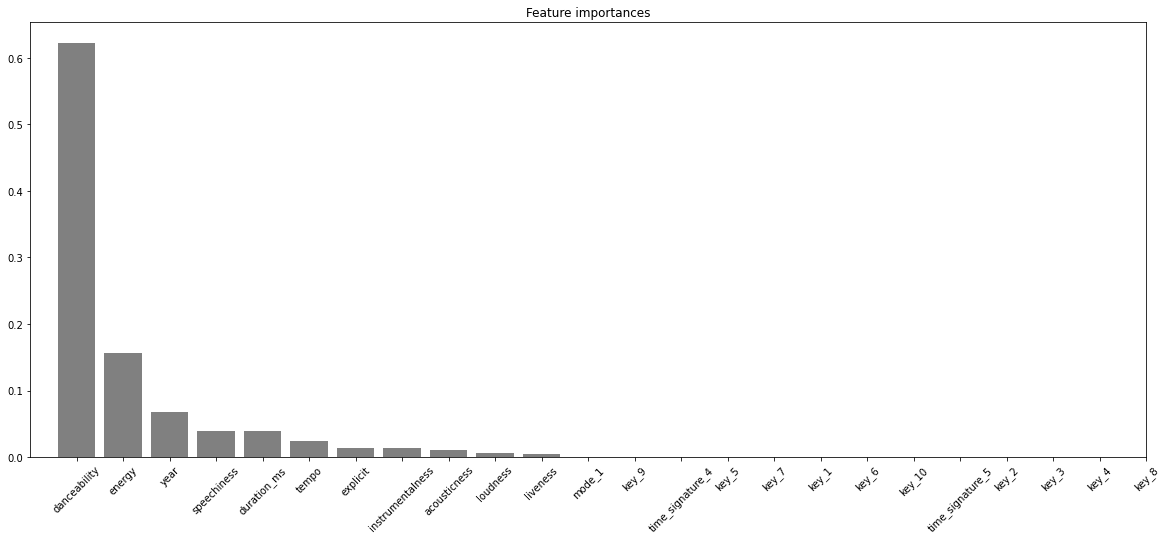

In [474]:
# Plot 
plt.figure(figsize=(20, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        tick_label=[list(X_train.columns)[x] for x in indices],
        color="grey",  align="center")
plt.xlim([-1, X.shape[1]])
_ = plt.xticks(rotation=45)

- In Decision Tree Regression, danceability is the most significant feature in predicting valence of songs, then follows the energy.

### Xgboost

- **max_depth** [default=6]:
Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value.
range: [0,∞]


- **colsample_bytree**:
colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

- **reg**:
squarederror: regression with squared loss.

- **learning_rate**:
The step size parameter of the gradient descent.

- **n_estimators**:
The number of decision trees


In [ ]:
pip install xgboost

In [475]:
import xgboost as xgb
from xgboost import XGBRegressor

In order to find the best parameters you could execute the following part of code. Because it takes too many time , is not possible so it is commented

In [476]:
#param_grid = {
      #  'max_depth':[5, 7, 10],
      #  'n_estimators':[300, 500, 1000],
      #  'learning_rate': [0.01, 0.02, 0.04],
       # 'colsample_bytree':[0.5, 0.7 ,0.8]}

In [478]:
from xgboost import XGBRegressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree = 0.7,eval_metric= 'mae',learning_rate = 0.01, 
                        max_depth = 10, n_estimators = 1000)
xgb_reg.fit(X_train, y_train)
predictions = xgb_reg.predict(X_test)
#scores =cross_val_score(xgb_reg, X_train, y_train,scoring="neg_mean_absolute_error", cv=5)
MAE = mean_absolute_error(predictions, y_test)
#Cross = np.mean(-scores)

print("Mean Absolute Error:", "{:.4f}".format(MAE))

#'Cross: ', "{:.4f}".format(Cross) , 

Mean Absolute Error: 0.1278


##### Importance  features

Text(0.5, 0.98, 'XGBOOST')

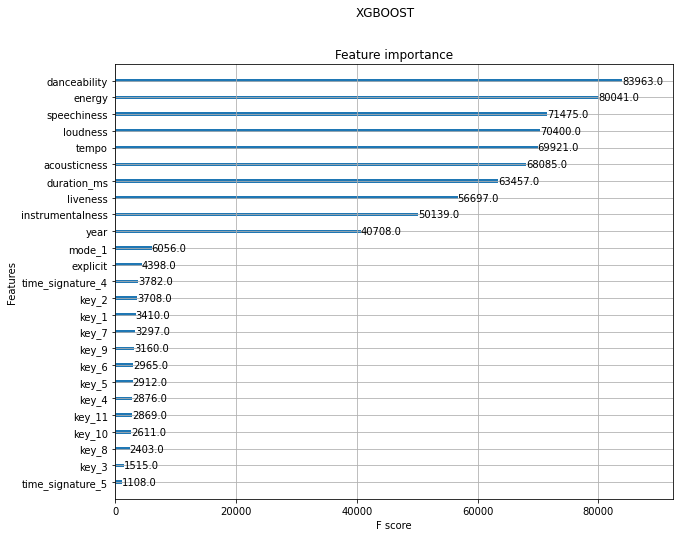

In [479]:
fig = plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_reg, ax = fig.gca())
fig.suptitle('XGBOOST')

- In Xgboost , danceability & energy are the most significant features in predicting valence of songs, then follows loudness


### Random Forest

- **n_estimatorsint**:
The number of trees in the forest.

- **min_samples_leafint**:
The minimum number of samples required to be at a leaf node. 

- **max_depth**:
The maximum depth of the tree. 

- **max_features**:
The number of features to consider when looking for the best split

In order to find the best parameters you could execute the following part of code. Because it takes too many time , is not possible so it is commented

In [480]:
#param_grid = {
   # "n_estimators":[200,300,500],
   # "max_depth":[10, 20, 50],
    #"max_features":[6,8,10,12,14,16]
    #'min_samples_leaf': [3, 5, 7]
#}

#rf_reg = RandomForestRegressor()

#rf_reg_tuned = GridSearchCV(estimator=rf_reg,param_grid=param_grid,cv=3,n_jobs=-1,verbose=2)

#rf_reg_tuned.fit(X_train, y_train)
#rf_reg_tuned.best_estimator

In [481]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(max_depth = 50, n_estimators = 500, max_features = 10, min_samples_leaf=5)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)

#scores =cross_val_score(random_forest, X_train, y_train,scoring="neg_mean_absolute_error", cv=5)
MAE_rf = mean_absolute_error(predictions, y_test)
#Cross_rf = np.mean(-scores)

print("Mean Absolute Error:", "{:.4f}".format(MAE_rf))
#'Cross: ', "{:.4f}".format(Cross_rf) 

Mean Absolute Error: 0.1310


##### Importance  features

In [482]:
importances = random_forest.feature_importances_



indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))

1. feature 0 danceability (0.329553)
2. feature 1 energy (0.173048)
3. feature 2 loudness (0.080279)
4. feature 4 acousticness (0.064894)
5. feature 8 duration_ms (0.062676)
6. feature 24 year (0.061300)
7. feature 3 speechiness (0.060641)
8. feature 7 tempo (0.052257)
9. feature 5 instrumentalness (0.047150)
10. feature 6 liveness (0.036417)
11. feature 23 explicit (0.014871)
12. feature 9 mode_1 (0.004116)
13. feature 10 time_signature_4 (0.003771)
14. feature 18 key_7 (0.001241)
15. feature 12 key_1 (0.001199)
16. feature 13 key_2 (0.001118)
17. feature 20 key_9 (0.000980)
18. feature 16 key_5 (0.000953)
19. feature 15 key_4 (0.000721)
20. feature 17 key_6 (0.000703)
21. feature 22 key_11 (0.000688)
22. feature 21 key_10 (0.000575)
23. feature 19 key_8 (0.000535)


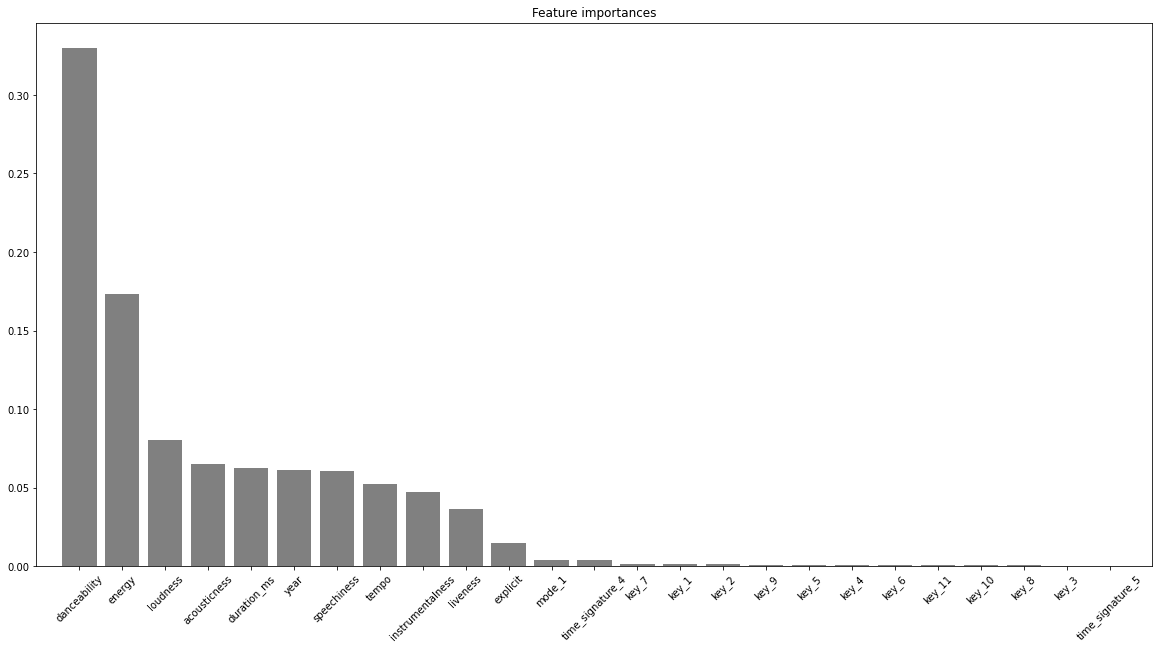

In [483]:
# Plot 
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        tick_label=[list(X_train.columns)[x] for x in indices],
        color="grey", align="center")
plt.xlim([-1, X_train.shape[1]])
_ = plt.xticks(rotation=45)

- In Random Forest , danceability is the most significant feature in predicting valence of songs, then follows energy

### Catboost

- **silent**:
True- Do not output any logging information
- **iterations**:
n_estimators
- **learning_rate**:
The step size parameter of the gradient descent.

- **depth**:
the depth of a tree
- **l2_leaf_reg**:
Coefficient at the L2 regularization term of the cost function.

In order to find the best parameters you could execute the following part of code. Because it takes too many time , is not possible so it is commented

In [484]:
# param_grid = {'iterations': [None, 300, 500, 1000],
#         'learning_rate': [None, 0.01, 0.05, 0.7],
#         'depth': [None, 6, 10, 20],
#         'l2_leaf_reg': [None, 0.1, 0.2, 0.5]
#         }



In [485]:
import catboost as cb

cb_reg = cb.CatBoostRegressor( silent = True,iterations=None,learning_rate=None,depth=None,l2_leaf_reg=None)
cb_reg.fit(X_train, y_train)
prediction = cb_reg.predict(X_test)
#scores =cross_val_score(cb_reg , X_train, y_train,scoring="neg_mean_absolute_error", cv=5)
MAE_cat = mean_absolute_error(predictions, y_test)
#Cross_cat = np.mean(-scores)

print("Mean Absolute Error:", "{:.4f}".format(MAE_cat))


#Cross: ', "{:.4f}".format(Cross_cat)

Mean Absolute Error: 0.1310


##### Importance  features

In [486]:
importances = cb_reg.feature_importances_



indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))

1. feature 0 danceability (26.841803)
2. feature 1 energy (21.192714)
3. feature 24 year (9.599713)
4. feature 3 speechiness (8.979065)
5. feature 8 duration_ms (6.483696)
6. feature 7 tempo (5.687209)
7. feature 4 acousticness (5.036206)
8. feature 5 instrumentalness (4.589653)
9. feature 2 loudness (3.839945)
10. feature 23 explicit (3.605264)
11. feature 6 liveness (2.642659)
12. feature 9 mode_1 (0.379932)
13. feature 12 key_1 (0.178168)
14. feature 13 key_2 (0.147964)
15. feature 15 key_4 (0.134621)
16. feature 16 key_5 (0.131587)
17. feature 10 time_signature_4 (0.106142)
18. feature 17 key_6 (0.101726)
19. feature 19 key_8 (0.055604)
20. feature 21 key_10 (0.054367)
21. feature 14 key_3 (0.053816)
22. feature 18 key_7 (0.050975)
23. feature 22 key_11 (0.048400)


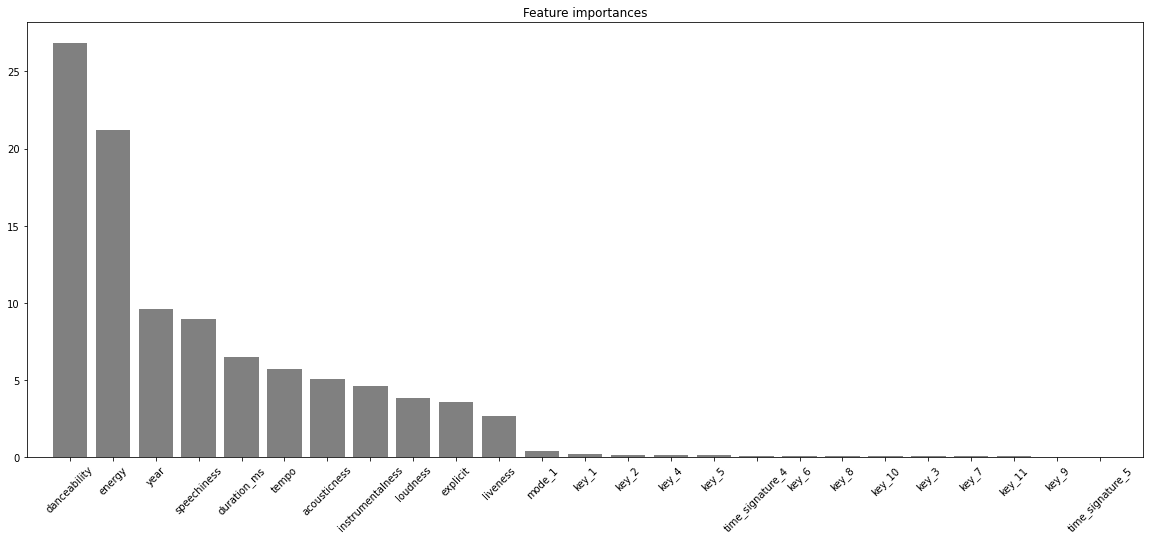

In [487]:
# Plot 
plt.figure(figsize=(20, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        tick_label=[list(X_train.columns)[x] for x in indices],
        color="grey", align="center")
plt.xlim([-1, X_train.shape[1]])
_ = plt.xticks(rotation=45)

- In Catboost , danceability & energy are the most significant features in predicting valence of songs, then follows year of release

### Extra tree

In [488]:
# param_grid = {
#  max_depth': [5, 7, 10]
#  min_samples_leaf': [1, 3, 4],
# 'min_samples_split': [2, 4, 6],
# 'n_estimators': [300, 400, 500]
#}

In [489]:
from sklearn.ensemble import ExtraTreesRegressor

extremely_rg = ExtraTreesRegressor(random_state=100, n_estimators=500 )
extremely_rg.fit(X_train, y_train)
predicted_extratree = extremely_rg.predict(X_test)
# scores =cross_val_score(extremely_rg, X_train, y_train,scoring="neg_mean_absolute_error", cv=5)
MAE_ext = mean_absolute_error(predicted_extratree, y_test)
# Cross = np.mean(-scores)

print("Mean Absolute Error:", "{:.4f}".format(MAE_ext))
# 'Cross: ', "{:.4f}".format(Cross) , 

Mean Absolute Error: 0.1315


##### Importance  features

In [498]:
importances = extremely_rg .feature_importances_



indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))

1. feature 0 danceability (0.299105)
2. feature 1 energy (0.159136)
3. feature 24 year (0.062182)
4. feature 4 acousticness (0.061443)
5. feature 3 speechiness (0.051227)
6. feature 2 loudness (0.050388)
7. feature 8 duration_ms (0.049491)
8. feature 5 instrumentalness (0.047967)
9. feature 7 tempo (0.047435)
10. feature 6 liveness (0.030327)
11. feature 23 explicit (0.020259)
12. feature 9 mode_1 (0.014588)
13. feature 18 key_7 (0.010734)
14. feature 13 key_2 (0.010120)
15. feature 20 key_9 (0.009978)
16. feature 12 key_1 (0.009658)
17. feature 16 key_5 (0.009255)
18. feature 15 key_4 (0.008742)
19. feature 10 time_signature_4 (0.008669)
20. feature 22 key_11 (0.008381)
21. feature 17 key_6 (0.008119)
22. feature 21 key_10 (0.007908)
23. feature 19 key_8 (0.007877)


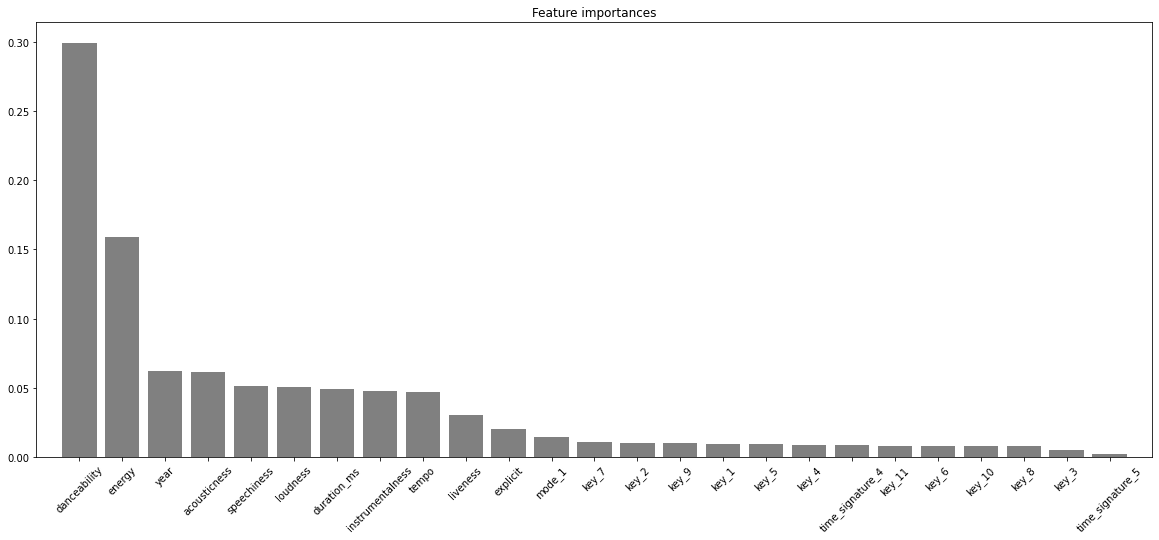

In [499]:
# Plot 
plt.figure(figsize=(20, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        tick_label=[list(X_train.columns)[x] for x in indices],
        color="grey", align="center")
plt.xlim([-1, X_train.shape[1]])
_ = plt.xticks(rotation=45)

- In Extra Tree , danceability is the most significant feature in predicting valence of songs, then follows energy

**The best results were achieved with the Catboost & Xgboost** (applied 5-k cross validation)

 ### Evaluation in another (out of sample) test dataset 

We will use the same methods for ETL

In [9]:
test_songs = pd.read_csv('spotify_ids.txt', header = None, names = ['track_id'])

In [10]:
test_songs.head(3)

,track_id
0,7lPN2DXiMsVn7XUKtOW1CS
1,5QO79kh1waicV47BqGRL3g
2,0VjIjW4GlUZAMYd2vXMi3b


In [11]:
len(test_songs)

1162

In [12]:
test_songs.drop_duplicates(subset='track_id', inplace=True)

In [504]:
client_credentials_manager = SpotifyClientCredentials('e6d084f421cf4399bc2df62483af93f9',
                                                     '0927ed2942164a45abad9a72a5998bc0')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


features = {}
all_track_ids = list(test_songs['track_id'])


def get_features(list_of_ids):
    
    features_func = {}
    all_track_ids = list_of_ids 

    start = 0
    num_tracks = 100
    while start < len(all_track_ids):
       
        tracks_batch = all_track_ids[start:start+num_tracks]
        features_batch = sp.audio_features(tracks_batch)
        features_func.update({ track_id : track_features 
                        for track_id, track_features in zip(tracks_batch, features_batch) })
        start += num_tracks
    return features_func

In [505]:
audio_features2 = get_features(all_track_ids)

In [506]:
test_tracks= pd.DataFrame.from_dict(audio_features2, orient='index')
test_tracks.head(2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
7lPN2DXiMsVn7XUKtOW1CS,0.585,0.436,10,-8.761,1,0.0601,0.7210,0.000013,0.105,0.132,143.874,audio_features,7lPN2DXiMsVn7XUKtOW1CS,spotify:track:7lPN2DXiMsVn7XUKtOW1CS,https://api.spotify.com/v1/tracks/7lPN2DXiMsVn...,https://api.spotify.com/v1/audio-analysis/7lPN...,242014,4
5QO79kh1waicV47BqGRL3g,0.680,0.826,0,-5.487,1,0.0309,0.0212,0.000012,0.543,0.644,118.051,audio_features,5QO79kh1waicV47BqGRL3g,spotify:track:5QO79kh1waicV47BqGRL3g,https://api.spotify.com/v1/tracks/5QO79kh1waic...,https://api.spotify.com/v1/audio-analysis/5QO7...,215627,4


In [507]:
test_tracks = test_tracks.drop(['type','id','uri','track_href','analysis_url'],axis=1)
test_tracks= test_tracks[(test_tracks.time_signature >=3)]


In [508]:
mode_dummies2 = pd.get_dummies(test_tracks['mode'], prefix='mode', drop_first=True)
test_tracks.drop(columns='mode', inplace=True)
test_tracks = test_tracks.join(mode_dummies2)

mode_dummies2 = pd.get_dummies(test_tracks['time_signature'], prefix='time_signature', drop_first=True)
test_tracks.drop(columns='time_signature', inplace=True)
test_tracks = test_tracks.join(mode_dummies2)


mode_dummies2 = pd.get_dummies(test_tracks['key'], prefix='key', drop_first=True)
test_tracks.drop(columns='key', inplace=True)
test_tracks = test_tracks.join(mode_dummies2)
test_tracks.head(3)


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
7lPN2DXiMsVn7XUKtOW1CS,0.585,0.436,-8.761,0.0601,0.72100,0.000013,0.1050,0.132,143.874,242014,...,0,0,0,0,0,0,0,0,1,0
5QO79kh1waicV47BqGRL3g,0.680,0.826,-5.487,0.0309,0.02120,0.000012,0.5430,0.644,118.051,215627,...,0,0,0,0,0,0,0,0,0,0
0VjIjW4GlUZAMYd2vXMi3b,0.514,0.730,-5.934,0.0598,0.00146,0.000095,0.0897,0.334,171.005,200040,...,0,0,0,0,0,0,0,0,0,0


In [509]:
track_features_test = get_track_features(all_track_ids)

In [510]:
extra_features_test= pd.DataFrame.from_dict(track_features_test, orient='index')
extra_features_test['year'] = extra_features_test['release_date'].apply(lambda x: int(x[0:4]))
extra_features_test.drop(columns='release_date', inplace=True)

extra_features_test['explicit'] = np.where(extra_features_test['explicit'] == True, 1, 0)

test_tracks = test_tracks.merge(extra_features_test, left_index=True, right_index=True, how='inner')
test_tracks

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,explicit,year
7lPN2DXiMsVn7XUKtOW1CS,0.585,0.436,-8.761,0.0601,0.72100,0.000013,0.1050,0.132,143.874,242014,...,0,0,0,0,0,0,1,0,1,2021
5QO79kh1waicV47BqGRL3g,0.680,0.826,-5.487,0.0309,0.02120,0.000012,0.5430,0.644,118.051,215627,...,0,0,0,0,0,0,0,0,1,2020
0VjIjW4GlUZAMYd2vXMi3b,0.514,0.730,-5.934,0.0598,0.00146,0.000095,0.0897,0.334,171.005,200040,...,0,0,0,0,0,0,0,0,0,2020
4MzXwWMhyBbmu6hOcLVD49,0.731,0.573,-10.059,0.0544,0.40100,0.000052,0.1130,0.145,109.928,205090,...,1,0,0,0,0,0,0,0,1,2020
5Kskr9LcNYa0tpt5f0ZEJx,0.907,0.393,-7.636,0.0539,0.45100,0.000001,0.1350,0.202,104.949,205458,...,1,0,0,0,0,0,0,0,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4lUmnwRybYH7mMzf16xB0y,0.596,0.650,-5.167,0.3370,0.13800,0.000000,0.1400,0.188,133.997,257428,...,0,0,0,0,0,1,0,0,1,2021
1fzf9Aad4y1RWrmwosAK5y,0.588,0.850,-6.431,0.0318,0.16800,0.002020,0.0465,0.768,93.003,187310,...,1,0,0,0,0,0,0,0,0,2021
3E3pb3qH11iny6TFDJvsg5,0.754,0.660,-6.811,0.2670,0.17900,0.000000,0.1940,0.316,83.000,209299,...,0,0,0,0,0,0,0,0,1,2021
3yTkoTuiKRGL2VAlQd7xsC,0.584,0.836,-4.925,0.0790,0.05580,0.000000,0.0663,0.484,104.973,202204,...,0,0,0,0,0,0,0,0,0,2021


In [511]:
test_features=test_tracks.drop(['valence'],axis=1)


- MAE:

#### XGBoost

In [512]:
y_pred = xgb_reg.predict(test_features)

mae_xgb_final= round(mean_absolute_error(test_tracks['valence'], y_pred),4)
print('XGBoost Regressor Model')
print( " \nMean Absolute Error:", "{:.4f}\n".format(mae_xgb_final))


XGBoost Regressor Model
 
Mean Absolute Error: 0.1403



#### Random_forest

In [513]:
y_pred = random_forest.predict(test_features)

mae_RF_FINAL = round(mean_absolute_error(test_tracks['valence'], y_pred),4)
print('random_forest')
print( " \nMean Absolute Error:", "{:.4f}\n".format(mae_RF_FINAL))


random_forest
 
Mean Absolute Error: 0.1442



####  Decision Tree

In [514]:
y_pred =tree.predict(test_features)

mae_tree_FINAL = round(mean_absolute_error(test_tracks['valence'], y_pred),4)
print('tree')
print( " \nMean Absolute Error:", "{:.4f}\n".format(mae_tree_FINAL))


tree
 
Mean Absolute Error: 0.1576



#### Extra Tree

In [321]:
y_pred =extremely_rg.predict(test_features)

mae_rg_FINAL = round(mean_absolute_error(test_tracks['valence'], y_pred),4)
print('extra-tree')
print( " \nMean Absolute Error:", "{:.4f}\n".format(mae_rg_FINAL))


extra-tree
 
Mean Absolute Error: 0.1448



#### CatBoost

In [322]:
y_pred =cb_reg.predict(test_features)

mae_cat_FINAL = round(mean_absolute_error(test_tracks['valence'], y_pred),4)
print('cat')
print( " \nMean Absolute Error:", "{:.4f}\n".format(mae_cat_FINAL))


cat
 
Mean Absolute Error: 0.1397



In [2]:
scores = {'Model': ['CatBoost', 'XGBoost', 'Random_forest', 'Extra Tree','Decesion Tree'],
            'Mean Absolute Error': [mae_cat_FINAL,mae_xgb_final,mae_RF_FINAL,mae_rg_FINAL,mae_tree_FINAL]} 
results = pd.DataFrame(scores)

NameError: name 'mae_cat_FINAL' is not defined

In [517]:
results.style.hide_index()

Model,Mean Absolute Error
CatBoost,0.139700
XGBoost,0.140300
Random_forest,0.144200
Extra Tree,0.144800
Decesion Tree,0.157600


The best model giving the lowest MAE is **CatBoost** Model with **0.1397** (MAE)